## Probabilistic Modeling of A/B Compartments from E1

This model infers A/B chromatin compartment structure from the first eigenvector (E1) of the Hi-C contact matrix using a Bayesian framework.

### Goals
- Replace hard sign-thresholding of E1 with a probabilistic compartment assignment.
- Quantify uncertainty in compartment calls for each genomic bin.
- Allow for modeling of missing E1 values due to low signal.

### Assumptions
- Each bin belongs to one of two latent states: A or B compartment.
- E1 values are generated from Gaussian distributions specific to each compartment.
- Prior belief: A has positive E1 values (μ ≈ 1), B has negative (μ ≈ -1).
- Bins are initially treated as independent; spatial structure can be added later. (markovian model)


### The data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

%config InlineBackend.figure_format = 'svg'



In [58]:


# Your input: csv file with only the E1 columns
resolution = 100000


y = pd.Series(pd.read_csv("../data/sperm_e1_100kb_arms.csv").values.flatten())

x = pd.Series(np.arange(0,y.shape[0])*resolution)

df = pd.DataFrame({"start": x, "e1": y})

df

start        e1
0             0       NaN
1        100000       NaN
2        200000       NaN
3        300000       NaN
4        400000       NaN
...         ...       ...
1529  152900000  0.527405
1530  153000000  0.496760
1531  153100000  0.535679
1532  153200000  0.520581
1533  153300000       NaN

[1534 rows x 2 columns]

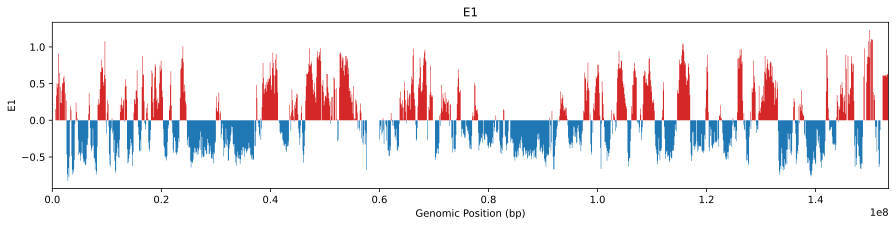

In [53]:
# Plot the data as a track (stairs for niceity)

fig, ax = plt.subplots(figsize=(15, 3))


x_stair = np.zeros(2*y.shape[0])
y_stair = np.zeros(2*y.shape[0])
x_stair[0::2] = x
x_stair[1::2] = x + resolution
y_stair[0::2] = y
y_stair[1::2] = y


ax.fill_between(x_stair, y_stair, where=(y_stair<0), color="tab:blue", ec='None')
ax.fill_between(x_stair, y_stair, where=(y_stair>0), color="tab:red", ec='None')
ax.set_xlim(0, df["start"].max()+resolution)
ax.set_xlabel("Genomic Position (bp)")
ax.set_ylabel("E1")
ax.set_title("E1");

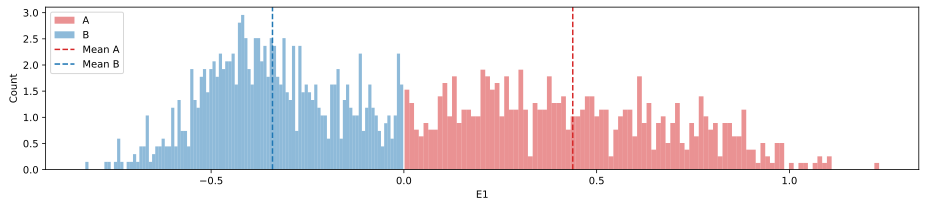

In [55]:
# Histogram of distribution of E1 values (A and B)

f, ax = plt.subplots(figsize=(13, 3))

# A compartments
ax.hist(y[y>0], bins=100, color="tab:red", alpha=0.5, label="A", density=True)
# B compartments
ax.hist(y[y<0], bins=100, color="tab:blue", alpha=0.5, label="B", density=True)
# Mean values (vline)
ax.axvline(y[y>0].mean(), color="tab:red", linestyle="--", label="Mean A")
ax.axvline(y[y<0].mean(), color="tab:blue", linestyle="--", label="Mean B")
plt.xlabel("E1")
plt.ylabel("Count")
plt.legend(loc='upper left')
plt.tight_layout()

### Model Specification

Before specifying the model, we need to layout the model structure. 

The model is a mixture of two Gaussian distributions, one for each compartment (A and B). Then a latent variable indicates the compartment assignment for each bin. The model. More formally;

### Model Description

We aim to model the A/B chromatin compartments using a probabilistic generative approach, rather than relying on deterministic eigenvector sign thresholding. Each genomic bin is modeled as belonging to one of two latent states (A or B), with corresponding expected E1 values.


#### Notation

Let:

- $y_i$: Observed E1 value at bin $i$
- $ z_i \in \{0, 1\} $: Latent compartment assignment (0 = B, 1 = A)
- $ \mu_A, \mu_B $: Mean E1 values for compartments A and B
- $ \sigma $: Shared standard deviation across bins
- $ p $: Prior probability of a bin belonging to compartment A

#### Generative Model

$$
\begin{aligned}
\mu_A &\sim \mathcal{N}(0.5, 0.5) \\
\mu_B &\sim \mathcal{N}(-0.5, 0.5) \\
\sigma &\sim \text{HalfNormal}(1) \\
p &\sim \text{Beta}(a, b) \quad \text{(e.g., } a = 2, b = 2 \text{ or something bimodal)} \\
z_i &\sim \text{Bernoulli}(p) \\
\mu_i &= z_i \cdot \mu_A + (1 - z_i) \cdot \mu_B \\
y_i &\sim \mathcal{N}(\mu_i, \sigma) \\
\end{aligned}
$$


This model allows us to infer both the compartment state and the uncertainty of the assignment, especially around boundaries between A and B compartments.




#### The Priors

- **$\mu_A$ and $\mu_B$**: We assume that the mean E1 values for compartments A and B are normally distributed around 0.5 and -0.5, respectively, with a standard deviation of 0.5. This reflects our prior belief about the expected E1 values for each compartment.
- **$\sigma$**: The standard deviation is modeled using a half-normal distribution, which ensures that it is always positive. This allows for flexibility in modeling the variability of E1 values within each compartment.
- **$p$**: The prior probability of a bin belonging to compartment A is modeled using a Beta distribution. This allows us to incorporate prior beliefs about the expected proportion of bins in each compartment. The parameters $a$ and $b$ can be adjusted to reflect different prior beliefs (e.g., bimodal distributions).
- **$z_i$**: The latent variable indicating the compartment assignment for each bin is modeled using a Bernoulli distribution, with the probability of being in compartment A given by $p$.
- **$y_i$**: The observed E1 values are modeled as normally distributed around the mean E1 value for the assigned compartment, with a shared standard deviation $\sigma$.
This generative model allows us to infer the compartment assignments and their associated uncertainties based on the observed E1 values, while also accounting for the variability in the data.

Let's look at a few different options for the Beta distribution. There are 3 main options:

- **Uniform**: $a = 1, b = 1$ (no prior preference for A or B)
- **Bimodal**: $a = 0.5, b = 0.5$ (most observations are certain to belong to A or B, but a few observations are hard to categorize—borders)
- **Unimodal**: $a = 2, b = 2$ (most obsevations are hard to categorize)

Here, they are visualized:

Sampling: [p]
Sampling: [p]
Sampling: [p]


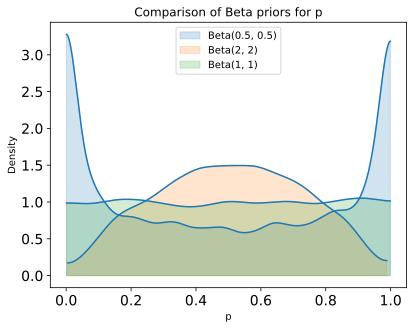

In [ ]:
# First, have a look at different Beta distributions for the prior on the latent state (z)

fig, ax = plt.subplots()

params = [(0.5, 0.5), (2, 2), (1, 1)]
colors = ["tab:blue", "tab:orange", "tab:green"]

for (a, b),col in zip(params, colors):
    with pm.Model() as model:
        p = pm.Beta("p", alpha=a, beta=b)
        prior = pm.sample_prior_predictive(samples=5000)
        az.plot_kde(prior.prior["p"].values, label=f"Beta({a}, {b})", ax=ax, fill_kwargs={"alpha": 0.2, "color":col})

ax.set_title("Comparison of Beta priors for p")
ax.set_xlabel("p")
ax.set_ylabel("Density")
ax.legend()
plt.show()


I find that the most useful prior is the bimodal one, as we have a strong prior belief that most bins are either A or B, but a few bins are hard to categorize. This is especially useful for the edges of compartments, where the E1 values are close to 0. The unimodal prior is not very useful, as it assumes that most bins are hard to categorize, which is not the case in our data. The uniform prior could be useful as the most uninformative prior —the least biased.

In [38]:
with pm.Model() as model:
    # Two means for A and B compartments
    mu_a = pm.Normal("mu_a", 0.5, 0.2)
    mu_b = pm.Normal("mu_b", -0.5, 0.2)
    sigma = pm.HalfNormal("sigma", 0.3)

    # Latent state for each bin: 0 = A, 1 = B
    p = pm.Beta("p", 0.5, 0.5)  # Prior belief: U-shaped distribution
    z = pm.Bernoulli("z", p=p, shape=y.shape[0])

    # per-bin expected mean
    mu = pm.math.switch(z, mu_a, mu_b)

    # Likelihood
    y_lik = pm.Normal("y_lik", mu=mu, sigma=sigma, observed=y)

    # Sample from the posterior
    trace = pm.sample(2000, tune=2000, cores=4, chains=4, target_accept=0.90)

/home/sojern/miniconda3/envs/pymc/lib/python3.13/site-packages/pymc/model/core.py:1311: ImputationWarning: Data in y_lik contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [mu_a, mu_b, sigma, p, y_lik_unobserved]
>BinaryGibbsMetropolis: [z]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 369 seconds.
/home/sojern/miniconda3/envs/pymc/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


In [45]:
with model:
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

Sampling: [y_lik_observed]


Output()

In [46]:
trace.posterior_predictive

<xarray.Dataset> Size: 192MB
Dimensions:               (chain: 4, draw: 2000, y_lik_observed_dim_0: 1458,
                           y_lik_dim_0: 1534)
Coordinates:
  * chain                 (chain) int64 32B 0 1 2 3
  * draw                  (draw) int64 16kB 0 1 2 3 4 ... 1996 1997 1998 1999
  * y_lik_observed_dim_0  (y_lik_observed_dim_0) int64 12kB 0 1 2 ... 1456 1457
  * y_lik_dim_0           (y_lik_dim_0) int64 12kB 0 1 2 3 ... 1531 1532 1533
Data variables:
    y_lik_observed        (chain, draw, y_lik_observed_dim_0) float64 93MB 0....
    y_lik                 (chain, draw, y_lik_dim_0) float64 98MB -0.166 ... ...
Attributes:
    created_at:                 2025-05-16T08:54:59.572880+00:00
    arviz_version:              0.21.0
    inference_library:          pymc
    inference_library_version:  5.22.0

In [48]:
az.plot_ppc(trace, num_pp_samples=1000);

In [42]:
az.summary(trace, var_names=['z'], hdi_prob=0.95).round(2)

/home/sojern/miniconda3/envs/pymc/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/sojern/miniconda3/envs/pymc/lib/python3.13/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/home/sojern/miniconda3/envs/pymc/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/sojern/miniconda3/envs/pymc/lib/python3.13/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/home/sojern/miniconda3/envs/pymc/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (b

mean    sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
z[0]     0.33  0.47       0.0        1.0       0.02     0.01     618.0   
z[1]     0.36  0.48       0.0        1.0       0.02     0.01     575.0   
z[2]     0.39  0.49       0.0        1.0       0.02     0.00     571.0   
z[3]     0.37  0.48       0.0        1.0       0.02     0.00     714.0   
z[4]     0.36  0.48       0.0        1.0       0.02     0.00     633.0   
...       ...   ...       ...        ...        ...      ...       ...   
z[1529]  1.00  0.04       1.0        1.0       0.00     0.01    5139.0   
z[1530]  1.00  0.04       1.0        1.0       0.00     0.01    6962.0   
z[1531]  1.00  0.04       1.0        1.0       0.00     0.01    4026.0   
z[1532]  1.00  0.04       1.0        1.0       0.00     0.01    4557.0   
z[1533]  0.34  0.47       0.0        1.0       0.02     0.01     549.0   

         ess_tail  r_hat  
z[0]        618.0   1.00  
z[1]        575.0   1.00  
z[2]        571.0   1.00  
z[3]        714.0   1.01  
z[4]        633.0   1.00  
...           ...    ...  
z[1529]    8000.0   1.00  
z[1530]    8000.0   1.00  
z[1531]    8000.0   1.00  
z[1532]    8000.0   1.00  
z[1533]     549.0   1.01  

[1534 rows x 9 columns]

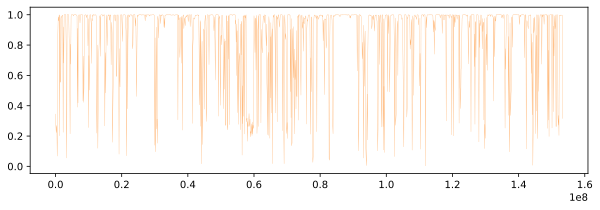

In [43]:
p_B = trace.posterior["z"].mean(dim=["chain", "draw"]).values
confidence = abs(p_B - 0.5) / 0.5
f,ax = plt.subplots(figsize=(10, 3))
ax.plot(x,confidence, color="tab:orange", alpha=0.6, lw=0.3, label="prediction confidence")

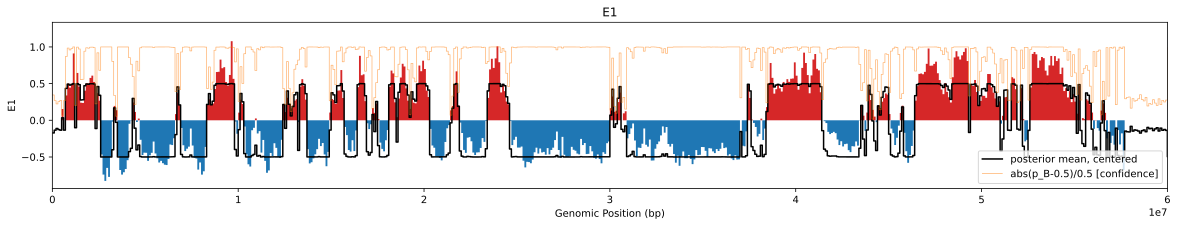

In [51]:
# Plot the data as a track (stairs for niceity)

fig, ax = plt.subplots(figsize=(20, 3))

# Stairs
x_stair = np.zeros(2*y.shape[0])
y_stair = np.zeros(2*y.shape[0])
x_stair[0::2] = x
x_stair[1::2] = x + resolution
y_stair[0::2] = y
y_stair[1::2] = y

ax.fill_between(x_stair, y_stair, where=(y_stair<0), color="tab:blue", ec='None')
ax.fill_between(x_stair, y_stair, where=(y_stair>0), color="tab:red", ec='None')

# Plot the posterior mean
post_mean_scaled = trace.posterior["z"].mean(dim=["chain", "draw"]).values-0.5
pms_stair = np.zeros(2*y.shape[0])
pms_stair[0::2] = post_mean_scaled
pms_stair[1::2] = post_mean_scaled
ax.plot(x_stair,pms_stair, color="k", label="posterior mean, centered")

# Plot the confidence in the compartment call as a curve
conf_stair = np.zeros(2*y.shape[0])
conf_stair[0::2] = confidence
conf_stair[1::2] = confidence
ax.plot(x_stair,conf_stair, color="tab:orange", alpha=0.6, lw=0.7, label="abs(p_B-0.5)/0.5 [confidence]")

ax.set_xlim(0, 60_000_000)
ax.set_xlabel("Genomic Position (bp)")
ax.set_ylabel("E1")
ax.set_title("E1")
ax.legend(loc="best");